<a href="https://colab.research.google.com/github/magnusross/nvkm/blob/main/initial_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path Based Sampling
-------------------------

From [this paper](https://arxiv.org/abs/2002.09309), we can get an explicit functional for a posterior sample of a gaussian process with a statiorary kernel $f \sim \mathcal{GP} (0, k(t, t'))$, given some inducing points, using the following equation:

$$ (f|\mathbf{u})(t) = \sum^{N_l}_{i=1} w_i\phi_i(t) + \sum^M_{j=1}v_jk(t, z_j)$$

where $\{\phi_i\}$ is a random Fourier basis, $w_i \sim \mathcal{N}(0, 1)$ and $\mathbf{v}=\mathbf{K}^{-1}_{m, m}(\mathbf{u}-\Phi\mathbf{w})$. The random fourier basis is obtained by first sampling $c_i \sim U(0, 2*\pi)$ and $\theta_i\sim FT(k)$, then the basis functions are given by,

$$ \phi_i = \sqrt{\frac{2}{N_l}}\cos(\theta_i t + c_i ). $$

$FT$ above is the Fourier transfrom of the kernel, which is the spectral density of the process. We will use the EQ kernel, given by $k(t, t') = \sigma^2 \exp(-0.5(t-t')^2/l^2) = \sigma^2 \exp(-0.5\tau^2/l^2)$ with $\tau=t-t'$. The Fourier transform of a Gaussian with varience $\sigma$, which we have up to a multiplicative consant, is a Gaussain with varience $1/\sigma$. So to sample from the PSD we just need to sample from a Gaussian with inverited varience.

In [ ]:
from jax.config import config 
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.scipy as jsp
from jax import vmap, grad, jit, value_and_grad
import jax.random as jrnd 

import scipy as osp 
import numpy as onp

import matplotlib.pyplot as plt

from functools import partial 


In [ ]:
@partial(jit, static_argnums=(0,))
def map2matrix(f, ts, tps, *args):
    return vmap(lambda ti: vmap(lambda tpi: f(ti, tpi, *args))(tps))(ts)

@jit
def l2p(l):
    """
    lengthscale to prescision 
    """
    return 0.5*(1/l**2)

def p2l(p):
    return 1/jnp.sqrt(2*p)

In [ ]:
@jit
def keq(t, tp, sig, l):
    return sig**2*jnp.exp(-0.5*(t-tp)**2/l**2)

@partial(jit, static_argnums=(0,))
def sample_eq_theta(N, l, key=jrnd.PRNGKey(123)):
    return jrnd.normal(key, (N,))/(l)

@partial(jit, static_argnums=(0,))
def sample_c(N, key=jrnd.PRNGKey(123)):
    return jrnd.uniform(key, (N, ), maxval=2*jnp.pi)
             
@jit
def phi(t, theta, c):
    return jnp.cos(theta*t + c)

@jit
def approx_prior(ti, ws, thetas, cs):
    return jnp.sqrt(2/len(thetas))*jnp.dot(ws, phi(ti, thetas, cs))
    
@jit
def get_v(zs, us, Kinv, ws, thetas, cs):
    Phi = vmap(lambda zi: jnp.sqrt(2/len(thetas))*phi(zi, thetas, cs))(zs) # matrix n x l
    return Kinv@(us-Phi@ws)

@jit
def posterior_update(ti, zs, us, Kinv, ws, thetas, cs, sigs, p):
    kv = vmap(lambda zi: keq(ti, zi, sigs, p))(zs)
    v = get_v(zs, us, Kinv, ws, thetas, cs)
    return jnp.dot(v, kv)

@jit
def posterior_sample(ts, zs, us, sigs, p, Nl=1000, jitter=1e-5, key=jrnd.PRNGKey(1)):
    subkeys = jrnd.split(key, 3)
    
    thetas = sample_eq_theta(Nl, p, key=subkeys[0])
    cs = sample_c(Nl, key=subkeys[1])
    ws = jrnd.normal(subkeys[2], (Nl,))
    
    K = map2matrix(keq, zs, zs, sigs, p)
    Kinv = jnp.linalg.inv(K+jitter*jnp.eye(len(us)))
    return vmap(lambda ti:  approx_prior(ti, ws, thetas, cs) +\
                           posterior_update(ti, zs, us, Kinv, ws, thetas, cs, sigs, p))(ts)
    
    

Now we also need some code to sample from the posterior in the traditional way to check that we have the right answer!

In [ ]:
@jit
def solve_posterior(t, x, y, Koo, Kop, Kpp, mo, mp):
    Loo = jsp.linalg.cholesky(Koo, lower=True)
    Kinvy = jsp.linalg.solve_triangular(
        Loo.T, jsp.linalg.solve_triangular(Loo, y - mo, lower=True))
    Lop = jsp.linalg.solve_triangular(Loo, Kop, lower=True)
    m_post = jnp.dot(Kop.T, Kinvy) + mp
    K_post = Kpp - jnp.dot(Lop.T, Lop) 
    return m_post, K_post

def classic_posterior(ts, zs, us, sigs, p, jitter=1e-8):
    Koo = map2matrix(keq, zs, zs, sigs, p)
    Kop = map2matrix(keq, zs, ts, sigs, p)
    Kpp = map2matrix(keq, ts, ts, sigs, p) 
    return solve_posterior(ts, zs, us, Koo, Kop, Kpp, 
                            jnp.zeros(len(zs)), jnp.zeros(len(ts)))



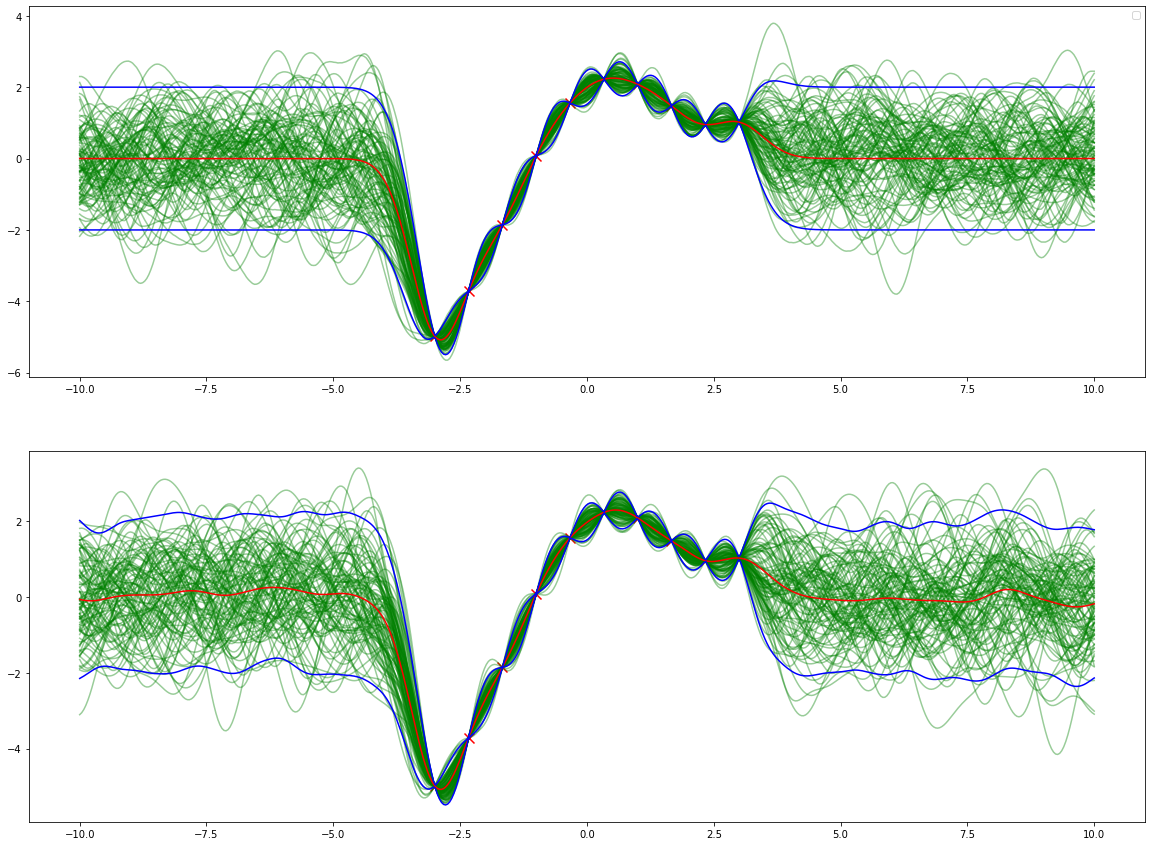

In [ ]:
key=jrnd.PRNGKey(1)
N_t = 500
N_s = 100

zs = jnp.linspace(-3, 3, 10)
us = 2*jnp.cos(zs) + zs
ts = jnp.linspace(-10, 10, N_t)

sig = 1. 
p = 0.5


fig, axs = plt.subplots(2, 1, figsize=(20, 15))
axs[0].scatter(zs, us, marker='x', c='red', s=100.)
axs[1].scatter(zs, us, marker='x', c='red', s=100.)

m_post, K_post = classic_posterior(ts, zs, us, sig, p)


ps_arr = []
for i in range(N_s):
    key, subkey=jrnd.split(key)
    ps = posterior_sample(ts, zs, us, sig, p, key=key)
    ps_arr.append(ps)
    os = jrnd.multivariate_normal(jrnd.PRNGKey(i+19), m_post, K_post+ 1e-5*jnp.eye(len(ts)))
    axs[0].plot(ts, os, c='green', alpha=0.4)
    axs[1].plot(ts, ps, c='green', alpha=0.4)
    
ps_arr = jnp.array(ps_arr)
m_post_path = jnp.mean(ps_arr, axis=0)
std_post_path = jnp.std(ps_arr, axis=0)

axs[0].plot(ts, m_post, c='red')
axs[0].plot(ts, m_post+2*jnp.sqrt(jnp.diag(K_post)), c='blue')
axs[0].plot(ts, m_post-2*jnp.sqrt(jnp.diag(K_post)), c='blue')
axs[0].set_title = 'Traditional Samples'
axs[0].legend()
axs[1].plot(ts, m_post_path, c='red')
axs[1].plot(ts, m_post_path+2*std_post_path, c='blue')
axs[1].plot(ts, m_post_path-2*std_post_path, c='blue')
axs[1].set_title = 'Efficient Samples' 
plt.show()

Below is a quirk/bug in jax random number generation that caught me out for a long time, even with different distributions using the same key twice gives correlated numbers!

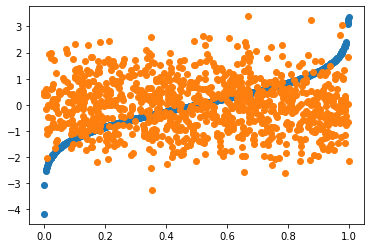

In [ ]:
from jax.random import uniform, normal, PRNGKey

key1 = PRNGKey(1)
key2 = PRNGKey(2)

us1 = uniform(key1, (1000,))
ns1 = normal(key1, (1000,))

ns2 = normal(key2, (1000,))

plt.scatter(us1, ns1)
plt.scatter(us1, ns2)

We can see that as the number of sample points becomes large, the new method is way faster!

In [ ]:
N_t = 10000
ts = jnp.linspace(-10, 10, N_t)
K = map2matrix(keq, ts, ts, 1., 1.) + 1e-8*jnp.eye(N_t)
%timeit posterior_sample(ts, zs, us, 1., 1., key=jrnd.PRNGKey(i))
%timeit jrnd.multivariate_normal(jrnd.PRNGKey(1), jnp.zeros(N_t), K)

The slowest run took 321.15 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.16 ms per loop
The slowest run took 4.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 127 ms per loop


Application to the GPCM model
-------------------------------------

### VI

GPCM model is, 

$$ f(t) = \int h(t-\tau) x(\tau) d\tau$$

where $h \sim \mathcal{GP}(0, k_h(t, t'))$ and $x \sim \mathcal{GP}(0, k_x(t, t'))$. This is intractable for exact infernence, so we using inducing points on $h$ and $x$ to make it tractable. We use a structured mean field approxmation to form a variational distibution, 

$$q(h, x, u_h, u_x) = p(h|u_h)p(x|u_x)q(u_h)q(u_x),$$ 

where the variational distributions over the inducing points are multivairte Gaussians. Using this q, we get the following expression for the free energy, 

$$ \mathcal{F} = \mathbb{E}[\log p(y|h, x)] - KL[q(u_x)||p(u_x)]-KL[q(u_h)||p(u_h)]$$

We then maximise this using doubly stochastic VI, by sampling from f, given the inducing points, and then evaluating the likelihood, which we make Gaussain for now. 

### Fast Sampling from $f$

We need to sample from

$$(f|u_h, u_x)(t) = \int (h|u_h)(t-\tau) (x|u_x)(\tau) d\tau$$

we can actually compute this integral by using explict samples from the filter and input process, as given by the efficient sampling methods in the paper. In the GPCM paper they use the Decaying Square exponential kernel for h, as this is nessecary to give finite $f$'s (integral must be bounded). This is a problem because the fast sampling method is only valid for stationary kernels. An equally valid way to ensure h is integralble is to to use a decaing window imposed on $h$, and then use regular SE kernel for $h$, 

$$(f|u_h, u_x)(t) = \int e^{-\alpha(t-\tau)^2}(h|u_h)(t-\tau) (x|u_x)(\tau) d\tau $$

This is the representation we will use from now on.

Samples from $h$ and $x$ given the inducing points are,

$$(x|u_x)(t) = \sum^{N_l}_{i=1} w^{(x)}_i\phi^{(x)}_i(t) + \sum^M_{j=1}v^{(x)}_jk_x(t, z^{(x)}_j)$$

$$ \begin{align}w^{(x)}_j &\sim \mathcal{N}(0, 1) \\ \phi^{(x)}_i(t) &= \sqrt{\frac{2}{N_l}}\cos(\theta_i^{(x)}t + c_i^{(x)}) \\ c^{(x)}_i &\sim U(0, 2\pi) \\ \theta^{(x)}_i &\sim FT(k_x) \\ \mathbf{v}^{(x)}&=\mathbf{K}^{-1}_{x,x}(\mathbf{u}^{(x)}-\Phi^{(x)}\mathbf{w}^{(x)})\end{align}$$

where $k_x$ is the kernel for $x$, and $\Phi$ is the $n \times l$ feature matrix of the basis functions evaluated at the inducing points, and $z^{(x)}$ are the inducing inputs. $h$ follows in the same way, 

$$(h|u_h)(t) = \sum^{N_l}_{i=1} w^{(h)}_i\phi^{(h)}_i(t) + \sum^M_{j=1}v^{(h)}_jk_h(t, z^{(h)}_j)$$

$$ \begin{align}w^{(h)}_j &\sim \mathcal{N}(0, 1) \\ \phi^{(h)}_i(t) &= \sqrt{\frac{2}{N_l}}\cos(\theta_i^{(h)}t + c_i^{(h)}) \\ c^{(h)}_i &\sim U(0, 2\pi) \\ \theta^{(h)}_i &\sim FT(k_h) \\ \mathbf{v}^{(h)}&=\mathbf{K}^{-1}_{h,h}(\mathbf{u}^{(h)}-\Phi^{(h)}\mathbf{w}^{(h)})\end{align}$$

We can now sub these into our expression for $(f|u_h, u_x)$ to get, 

$$\begin{align} (f|u_h, u_x)(t) &= \sum^{N_l}_{i=1}\sum^{N_l}_{j=1} w^{x}_j w^{h}_i \underbrace{\int e^{-\alpha(t-\tau)^2}\phi_i^{(h)}(t-\tau)\phi_j^{(x)}(\tau)d\tau}_{I_A}       \\    &+ \sum^{N_l}_{i=1}\sum^{M}_{j=1} v^{x}_j w^{h}_i \underbrace{\int e^{-\alpha(t-\tau)^2}\phi_i^{(h)}(t-\tau)k_x(\tau, z^{(x)}_j)d\tau}_{I_B}  \\   &+ \sum^{M}_{i=1}\sum^{N_l}_{j=1} w^{x}_j v^{h}_i \underbrace{\int e^{-\alpha(t-\tau)^2}k_h(t-\tau, z^{(h)}_i)\phi_j^{(x)}(\tau)d\tau}_{I_C} \\ &+ \sum^{M}_{i=1}\sum^{M}_{j=1} v^{x}_j v^{h}_i \underbrace{\int e^{-\alpha(t-\tau)^2}k_h(t-\tau, z^{(h)}_i)k_x(\tau, z^{(x)}_j)d\tau}_{I_D}\end{align}$$

Fortunately, the integrals can be computed analytically!

We have, 

$$ I_A = \frac{1}{N_l}\frac{\sqrt{\pi }}{\sqrt{\alpha}} e^{-\frac{(\theta_h+\theta_x)^2}{4a}}\left( \cos (c_h - c_x - t \theta_x)+  e^{\frac{\theta_x \theta_h}{\alpha}}\cos ( c_h + c_x + t \theta_x)\right)$$

In [ ]:
@jit
def integ_A(t, thetx, theth, cx, ch, a):
    # print(t, thetx, theth, cx, ch, a)
    coeff = jnp.sqrt(jnp.pi/a)/len(theth)
    # print(coeff)
    e1 = (thetx+theth)**2/(4*a)
    e2 = theth*thetx/a
    # print(e1)
    # print(e2)
    # print(jnp.cos(ch - cx - t*thetx) + jnp.exp(e2)*jnp.cos(cx + ch + t*thetx))
    return coeff*jnp.exp(-e1)*(jnp.cos(ch - cx - t*thetx) + jnp.exp(e2)*jnp.cos(cx + ch + t*thetx))

assert jnp.isclose(integ_A(1., 2., jnp.array([3.]),  4., 5., 6.), 2*0.0705147)

In [ ]:

t = 0.2
a = 3. 
tx, th, cx, ch = 1., 2., 3., 4.
f_int = lambda tau: 2.*jnp.exp(-a*(t-tau)**2)*jnp.cos(th*(t-tau)+ch)*jnp.cos(tx*tau+cx)
print(osp.integrate.quad(f_int, 
                    -onp.inf, onp.inf)[0])
print(integ_A(t, tx, jnp.array([th]), cx, ch, a))

0.9095442143472456
[0.90954421]


$$ I_B = \sigma^2_x \sqrt{\frac{2}{N_l}} \sqrt{\frac{\pi }{a+p_x}} e^{-\frac{4 a p_x (t-z_x)^2+\theta_h^2}{4 (a+p_x)}} \cos \left(\frac{a c_h+p_x (c_h+\theta_h (t-z_x))}{a+p_x}\right)$$

In [ ]:
@jit
def integ_B(t, zx, theth, ch, px, a, sigx):
    coeff = sigx**2*jnp.sqrt(2*jnp.pi/(len(theth)*(a+px)))
    ea = -(4*a*px*(t-zx)**2 + theth**2)/(4*(a+px))
    ca = (a*ch+px*(ch + theth*(t-zx)))/(a+px)
    return coeff*jnp.exp(ea)*jnp.cos(ca)

assert jnp.isclose(integ_B(1., 1.3, jnp.array([2.]), 3., 1.2, 1.1, 1.), -jnp.sqrt(2)*0.6455574698242538)

$$I_C =\sigma^2_h\sqrt{\frac{2}{N_l}} \sqrt{\frac{\pi }{a+p_h}}e^{-\frac{4 a p_h z_h^2+\theta_x^2}{4 (a+p_h)}} \cos \left(\theta_x \left(t-\frac{p_h z_h}{a+p_h}\right)+c_x\right)$$

In [ ]:
@jit
def integ_C(t, zh, thetx, cx, ph, a, sigh):
    coeff = sigh**2*jnp.sqrt(2*jnp.pi/(len(thetx)*(a+ph)))
    ea = -(4*a*ph*zh**2+thetx**2)/(4*(a+ph))
    ca = thetx*(t-(ph*zh)/(a+ph))+cx
    return coeff*jnp.exp(ea)*jnp.cos(ca)

assert jnp.isclose(integ_C(1., 2., jnp.array([3.]), 1.2, 1.3, 1.1, 1.), 
                       jnp.sqrt(2)*0.02404009401707997)

$$ I_D = \sigma^2_h\sigma^2_x\sqrt{\frac{\pi }{a+p_h+p_x}} \exp \left(-\frac{a \left(p_h z_h^2+p_x (t-z_x)^2\right)+p_h p_x (-t+z_h+z_x)^2}{a+p_h+p_x}\right)$$

In [ ]:
@jit
def integ_D(t, zx, zh, px, ph, a, sigx, sigh):
    coeff = sigh**2*sigx**2*jnp.sqrt(jnp.pi/(a+ph+px))
    ea1 = a*(ph*zh**2+px*(t-zx)**2)
    ea2 = ph*px*(zh+zx-t)**2
    return coeff*jnp.exp(-(ea1+ea2)/(a+ph+px))

assert jnp.isclose(integ_D(1., 2., 3., 1.2, 1.3, 1.1, 1., 1.), 0.0000176795)

In [ ]:
@jit
def gpcm_sample(key, ts, zhs, uhs, zxs, uxs, invKhh, invKxx,
                            lh=1., lx=1.,
                            sigh=1., sigx=1., 
                            a=1., Nl=500, jitter=1e-6):

    subkeys = jrnd.split(key, 6)
    
    ph, px = l2p(lh), l2p(lx)
    
    theths = sample_eq_theta(Nl, lh, key=subkeys[0])    
    thetxs = sample_eq_theta(Nl, lx, key=subkeys[1])
    
    chs = sample_c(Nl, key=subkeys[2])
    cxs = sample_c(Nl, key=subkeys[3])
    
    whs = jrnd.normal(subkeys[4], (Nl,))
    wxs = jrnd.normal(subkeys[5], (Nl,))
    
    vh = get_v(zhs, uhs, invKhh, whs, theths, chs)
    vx = get_v(zxs, uxs, invKxx, wxs, thetxs, cxs)

    mA = vmap(lambda ti: 
             vmap(lambda thetx, cx: 
                  integ_A(ti, thetx, theths, cx, chs, a))(thetxs, cxs))(ts)#nt x l x l

    mB = map2matrix(integ_B, ts, zxs, theths, chs, px, a, sigx) # nt x nx x l
    mC = map2matrix(integ_C, ts, zhs, thetxs, cxs, ph, a, sigh) # nt x nh x l
    mD = map2matrix(integ_D, ts, zxs, zhs, px, ph, a, sigx, sigh) # nt x nx x nh
    sA = jnp.einsum('i, j, kij', wxs, whs, mA)#*jnp.sum(whs)
    sB = jnp.einsum('i, j, kij', vx, whs, mB)
    sC = jnp.einsum('i, j, kij', vh, wxs, mC)
    sD = jnp.einsum('i, j, kij', vx, vh, mD)

    return   sA + sB + sC + sD



In [ ]:
@jit
def time_test(thets, ts, cs):
  mA = vmap(lambda ti: 
          vmap(lambda thetx, cx: 
                integ_A(ti, thetx, thets, cx, cs, 0.1))(thets, cs))(ts)
  sA = jnp.einsum('i, j, kij', thets, thets, mA)
  return sA


# %load_ext memory_profiler
# %memit time_test(jnp.ones(1000), jnp.ones(100), jnp.ones(1000)).block_until_ready()
%timeit time_test(jnp.ones(1000), jnp.ones(100), jnp.ones(1000)).block_until_ready()

The slowest run took 47.20 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 10.7 ms per loop


In [ ]:
Nt =500
Nx = 88
Nh = 20

jitter = 1e-5
lx = .5
lh = 3.
a =0.1

tmax=44

subkeys = jrnd.split(jrnd.PRNGKey(10), 4)

ts = jnp.linspace(-tmax, tmax, Nt)
zxs = jnp.linspace(-tmax, tmax, Nx)



ths = jnp.linspace(-10, 10, 120)
zhs = jnp.linspace(-10, 10, Nh)

Kxx = map2matrix(keq, zxs, zxs, 1., lx)
Khh = map2matrix(keq, zhs, zhs, 1., lh)
invKxx = jnp.linalg.inv(Kxx + jitter*jnp.eye(Nx))
invKhh = jnp.linalg.inv(Khh + jitter*jnp.eye(Nh))


uxs = jrnd.multivariate_normal(subkeys[0], jnp.zeros(Nx), Kxx + jitter*jnp.eye(Nx))
s = posterior_sample(ts, zxs, uxs, 1., lx, key=subkeys[1])

uhs = keq(0., zhs, 1., 1.)# jrnd.multivariate_normal(subkeys[2], jnp.zeros(Nh), Khh + jitter*jnp.eye(Nh))# 
sh = posterior_sample(ths, zhs, uhs, 1., lh, key=subkeys[3], jitter=jitter)


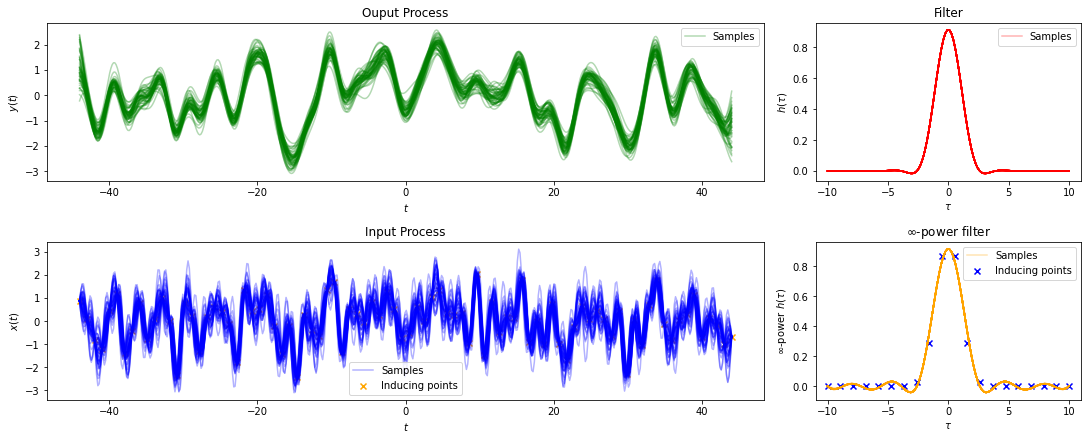

In [ ]:
N = 50

# fig, axs = plt.subplots(2, 1, figsize=(20, 7))
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig.add_gridspec(2, 5)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[1, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[1, 3:])

ax2.scatter(zxs, uxs, c='orange', marker='x', alpha=1., label='Inducing points')
ax4.scatter(zhs, uhs, c='blue', marker='x', alpha=1., label='Inducing points')
key = jrnd.PRNGKey(112)
for i in range(N):
    key, skey = jrnd.split(key)

    os = gpcm_sample(skey, ts, zhs, uhs, zxs, uxs, invKhh, invKxx,
                 lx=lx, lh=lh, a=a)
    xs = posterior_sample(ts, zxs, uxs, 1., lx, key=skey)

    phs = posterior_sample(ths, zhs, uhs, 1., lh, key=skey)
    hs = jnp.exp(-a*(ths)**2)*phs

    # print(jnp.any(jnp.isnan(os)))

    ax1.plot(ts, os, c='green', alpha=0.3, label='Samples' if i == 0 else "")
    ax2.plot(ts, xs, c='blue', alpha=0.3, label='Samples' if i == 0 else "")
    ax3.plot(ths, hs, c='red', alpha=0.3, label='Samples' if i == 0 else "")
    ax4.plot(ths, phs, c='orange', alpha=0.3, label='Samples' if i == 0 else "")

ax1.set_ylabel('$y(t)$')
ax1.set_xlabel('$t$')
ax2.set_ylabel('$x(t)$')
ax2.set_xlabel('$t$')
ax3.set_ylabel('$h(\\tau)$')
ax3.set_xlabel('$\\tau$')
ax4.set_ylabel('$\infty$-power $h(\\tau)$')
ax4.set_xlabel('$\\tau$')
ax1.set_title('Ouput Process')
ax2.set_title('Input Process')
ax3.set_title('Filter')
ax4.set_title('$\\infty$-power filter')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# plt.savefig('eq.png', dpi=500)
plt.show()


I am very confused about how we should do sampling using the variational prior, it seems like the options are:

1. Use the K matrix from equations 4 in the eff paper in equation 13 from the eff paper (i.e. my get V), and then optimize using the gradients. In this case how do we include the mean function? 

2. Sample from normal with vairational parameters to produce u stochastically, then plug this into get_v. This would definitly be correct but doen't seem the most effiecient way to do it at all, could potenially then have a joint distribution over q(ux, uh) aslo?


Fairly sure last way is the right way!

In [ ]:
@jit
def get_KLT(LC, invKu, mu, N, jitter=1e-8):
    '''
    Get KL Terms 
    '''
    C = LC@LC.T
    detKu = 1/jnp.linalg.det(invKu + jitter*jnp.eye(len(invKu)))
    # print(detKu)
    detC = jnp.prod(jnp.diag(LC)**2)
    mt = -0.5*(jnp.dot(mu.T, invKu@mu) + jnp.trace(invKu@C))
    st = jnp.log(jnp.sqrt(detC)/jnp.sqrt(detKu)) + 0.5*N
    return mt + st

@jit
def esitmated_loglikelihood(y, samples, sigy):
    """
    gaussian likelihood 
    """
    Nt = samples.shape[1]
    Ns = samples.shape[0]
    C = -0.5*Nt*jnp.log(2*jnp.pi*sigy**2)
    return C - (1/Ns)*(1/(2*sigy**2))*jnp.sum((y - samples)**2)
  
# from functools import partial
# @partial(jit, static_argnums=(1))
def estimated_F(key, pars, dpars, data=None, Ns=2):

    if not data:
      t = pars["t"]
      y = pars["y"]
    else:
      t = data[0]
      y = data[1]
    
    skey = jrnd.split(key, 3)

    Lh = jsp.linalg.tril(dpars["Lh"])
    Lx = jsp.linalg.tril(dpars["Lx"])

    uhs = jrnd.multivariate_normal(skey[0], dpars["muh"], Lh@Lh.T, (Ns,))
    uxs = jrnd.multivariate_normal(skey[1], dpars["mux"], Lx@Lx.T, (Ns,))
    # sh = jrnd.normal(skey[0], (Ns, Lh.shape[0]))
    # uhs = vmap(lambda si: jsp.linalg.solve_triangular(Lh, si, lower=True) + dpars["muh"])(sh)
    # uhs = Lh@sh + dpars["muh"]
    # uhs = jnp.einsum('ij, kj, j', Lh, sh, dpars["muh"]).T
    # sx = jrnd.normal(skey[1], (Ns, Lx.shape[0]))
    # uxs = vmap(lambda si: jsp.linalg.solve_triangular(Lx, si, lower=True) + dpars["mux"])(sx)
    # uxs = jnp.einsum('ij, kj, j', Lx, sx, dpars["mux"]).T
    # print(y.shape)

    samples = vmap(lambda uhi, uxi, keyi: 
                  gpcm_sample(keyi, t, pars["zhs"], uhi, pars["zxs"], uxi, 
                  pars["invKhh"], pars["invKxx"], 
                  lx=pars["lx"], lh=pars["lh"], sigx=pars["sigx"], 
                  sigh=dpars["sigh"], a=pars["a"]))(uhs, uxs, jrnd.split(skey[2], Ns))

    return -(get_KLT(Lx, pars["invKxx"], dpars["mux"], dpars["mux"].shape[0]) + \
           get_KLT(Lh, pars["invKhh"], dpars["muh"], dpars["muh"].shape[0]) + \
           esitmated_loglikelihood(y, samples, pars["sigy"]))

def init_pars(t, y, zhs, zxs, 
              key=jrnd.PRNGKey(10),
              lx=0.5, lh=3., sigy=0.5, sigh=1., sigx=1., a=0.1, Ns=50, jitter=1e-6):

    Nh = zhs.shape[0]
    Nx = zxs.shape[0]
    
    Kxx = map2matrix(keq, zxs, zxs, 1., lx)
    Khh = map2matrix(keq, zhs, zhs, 1., lh)
    invKxx = jnp.linalg.inv(Kxx + jitter*jnp.eye(Nx))
    invKhh = jnp.linalg.inv(Khh + jitter*jnp.eye(Nh))

    subkeys = jrnd.split(key, 2)
    dpars = {
        "muh": jrnd.multivariate_normal(subkeys[0], jnp.zeros(Nh), Khh + jitter*jnp.eye(Nh)),
        "mux": jrnd.multivariate_normal(subkeys[1], jnp.zeros(Nx), Kxx + jitter*jnp.eye(Nx)),
        "Lh": jnp.linalg.cholesky(Khh + jitter*jnp.eye(Nh)) *0.3,
        "Lx": jnp.linalg.cholesky(Kxx + jitter*jnp.eye(Nx)) *0.3,
        "sigh": sigh}

    pars = {"t": t, 
            "y": y,
            "zhs": zhs,
            "zxs": zxs, 
            "Kxx": Kxx, 
            "Khh": Khh, 
            "invKxx": invKxx,
            "invKhh": invKhh,
            "lx": lx, 
            "lh": lh, 
            "sigy": sigy,
            "sigx": sigx,
            "a": a,
            }

    return pars, dpars




In [ ]:
import jax.experimental.optimizers as opt 
def plot(txs, ths, pars, dpars, N=30, key=jrnd.PRNGKey(10)):
    # fig, axs = plt.subplots(2, 1, figsize=(20, 7))
    fig = plt.figure(constrained_layout=True, figsize=(15, 6))
    gs = fig.add_gridspec(2, 5)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[1, :3])
    ax3 = fig.add_subplot(gs[0, 3:])
    ax4 = fig.add_subplot(gs[1, 3:])

    ax2.scatter(pars['zxs'], dpars['mux'], c='orange', marker='x', alpha=1., label='Inducing points')
    ax4.scatter(pars['zhs'], dpars['muh'], c='blue', marker='x', alpha=1., label='Inducing points')
    ax1.scatter(pars["t"], pars["y"], c='red', marker='x', alpha=1., label='Data')
    Lh = jsp.linalg.tril(dpars["Lh"])
    Lx = jsp.linalg.tril(dpars["Lx"])


    for i in range(N):
        skey = jrnd.split(key, 6)
        key = skey[5]
        uhs = jrnd.multivariate_normal(skey[0], dpars["muh"], Lh@Lh.T)
        uxs = jrnd.multivariate_normal(skey[1], dpars["mux"], Lx@Lx.T)

        os = gpcm_sample(skey[2], txs, pars['zhs'], uhs, 
                                             pars['zxs'], uxs, 
                                             pars['invKhh'], pars['invKxx'],
                                             lx=pars["lx"], lh=pars['lh'], a=pars['a'])
        xs = posterior_sample(txs, pars['zxs'], uxs, 1., lx, key=skey[3])

        phs = posterior_sample(ths, pars['zhs'], uhs, 1., lh, key=skey[4])
        hs = jnp.exp(-a*(ths)**2)*phs

        # print(jnp.any(jnp.isnan(os)))

        ax1.plot(txs, os, c='green', alpha=0.3, label='Samples' if i == 0 else "")
        ax2.plot(txs, xs, c='blue', alpha=0.3, label='Samples' if i == 0 else "")
        ax3.plot(ths, hs, c='red', alpha=0.3, label='Samples' if i == 0 else "")
        ax4.plot(ths, phs, c='orange', alpha=0.3, label='Samples' if i == 0 else "")

    ax1.set_ylabel('$y(t)$')
    ax1.set_xlabel('$t$')
    ax2.set_ylabel('$x(t)$')
    ax2.set_xlabel('$t$')
    ax3.set_ylabel('$h(\\tau)$')
    ax3.set_xlabel('$\\tau$')
    ax4.set_ylabel('$\infty$-power $h(\\tau)$')
    ax4.set_xlabel('$\\tau$')
    ax1.set_title('Ouput Process')
    ax2.set_title('Input Process')
    ax3.set_title('Filter')
    ax4.set_title('$\\infty$-power filter')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.savefig('eq.png', dpi=500)
    plt.show()

    
def maximize_bound(its, pars, dpars, lr=1e-2, batch_size=None, key=jrnd.PRNGKey(10)):
    opt_init, opt_update, get_params = opt.adam(lr)
  
    opt_state = opt_init(dpars)
    fig, ax = plt.subplots()
    plt.yscale("log")
    for i in range(its):
        
        if batch_size:
          
          rnd_idx = jrnd.choice(key, len(pars["y"]), shape=(batch_size,))

          y_b = pars["y"][rnd_idx]
          t_b = pars["t"][rnd_idx]
          # print(rnd_idx)
        else:
          y_b = pars["y"]
          t_b = pars["t"]
          
        for k in dpars.keys():

            dpars[k] = get_params(opt_state)[k]
        # print(get_params(opt_state))
        value, grads = value_and_grad(estimated_F, argnums=2)(
            key, pars, dpars, data=(t_b, y_b), Ns=40)
        # print(value)

        if jnp.any(jnp.isnan(value)):
            print("nan F!!")
            # print(get_params(opt_state))
            return get_params(opt_state)
        elif i % 1 == 0 and i > 1:
            print(f"it: {i} F: {value} ")
            ax.scatter(i, value)
    
        opt_state = opt_update(i, grads, opt_state)
        key, skey = jrnd.split(key)
        print(dpars["sigh"])
        print(dpars["Lh"].max())
        print(dpars["Lx"].max())
        print(dpars["muh"].max())
        print(dpars["mux"].max())
        
        if i % 50 == 0:
          plot(jnp.linspace(-50, 50, 400), ths, pars, dpars, key=key, N=10)

    ax.legend()           
    plt.show()


In [ ]:
Nt = 880
Nx = 88
Nh = 20

jitter = 1e-5

lh = 1.
a = .45
sigy = 0.3
tmax=44 

key = jrnd.split(jrnd.PRNGKey(10), 1)

ts = jnp.linspace(-tmax, tmax, Nt)

zxs = jnp.linspace(-tmax, tmax, Nx)
lx = 1.
K = map2matrix(keq, ts, ts, 1., 1.)
y = jrnd.multivariate_normal(jrnd.PRNGKey(9), jnp.zeros(Nt), K+ 1e-5*jnp.eye(Nt)) + \
    0.3*jrnd.normal(jrnd.PRNGKey(10), (Nt,))

thmax = 6
ths = jnp.linspace(-thmax, thmax, 120)
zhs = jnp.linspace(-thmax, thmax, Nh)

1.0
0.3000001499999625
0.3000001499999625
0.7233849364218674
2.392352126345563


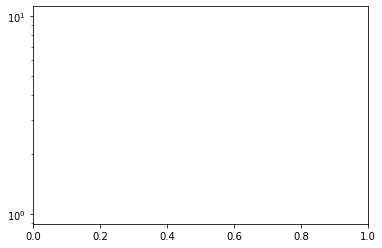

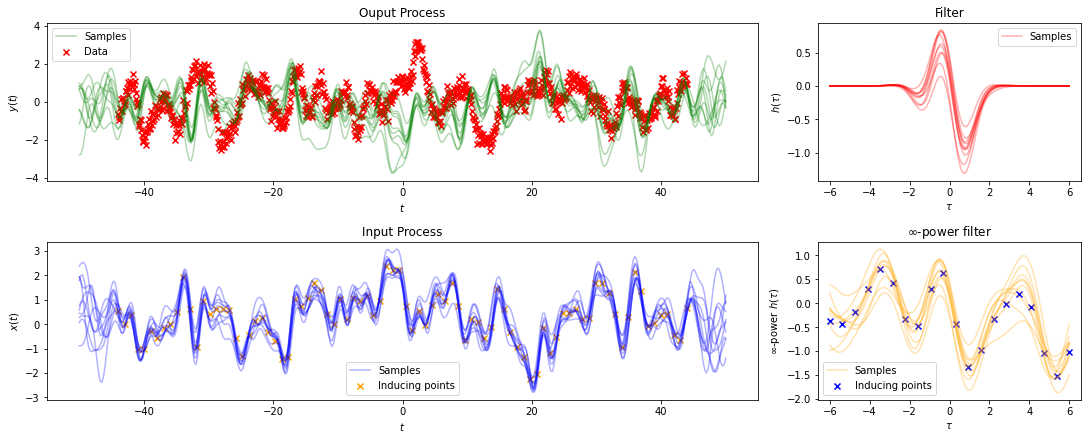

0.9700000000001063
0.3300001499010653
0.2700993430421001
0.6933849364340371
2.3623521263512743
it: 2 F: 1010.7396738120586 
0.9441681990825391
0.3586742644533704
0.29414928376667937
0.712996407373224
2.334502620916369
it: 3 F: 1030.150326771156 
0.9226368824099379
0.38373286789241323
0.3146703400546715
0.7305948032098879
2.306098270763542
it: 4 F: 1022.1357506160408 
0.9040349718349207
0.40435779517239195
0.33471893753921195
0.7342637492315186
2.278025013569921
it: 5 F: 994.2485957644856 
0.8861351912694521
0.4135166905538383
0.3618251806140486
0.7283947784802889
2.250949591724332
it: 6 F: 909.818906144087 
0.8747866493274025
0.4182166586227195
0.3838584784880229
0.7187517196437834
2.225027519782012
it: 7 F: 912.7128086483169 
0.8680922710080057
0.4251906976824511
0.4037418588401943
0.7101289113256112
2.200650298859374
it: 8 F: 1043.3801181099184 
0.8655409445197609
0.4363095998055231
0.4279020202948872
0.7061989719431275
2.1754064209261097
it: 9 F: 879.613368913642 
0.8713660486898273

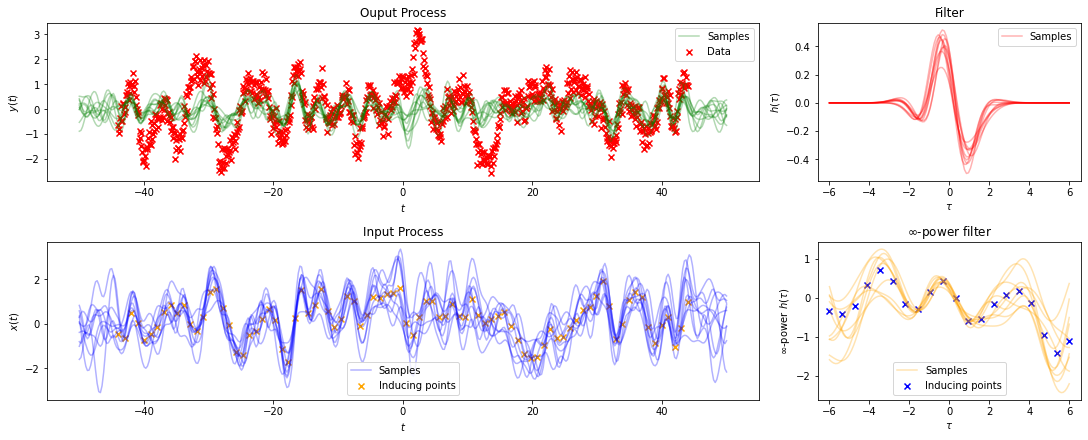

it: 51 F: 483.3167898856988 
1.0158047266120975
0.6989839736222677
0.5745465750853327
0.7110129935135262
1.9195579307580182
it: 52 F: 560.7108508825339 
1.0127404974274223
0.7013769864727364
0.5797346286412464
0.7093384998502754
1.9226858233782766
it: 53 F: 564.9825264419462 
1.0093094821005684
0.7040499794923691
0.5875507716509929
0.7075469572170018
1.9225282843057958
it: 54 F: 413.7511582296929 
1.0058177489474955
0.7065982838879633
0.5966139352239815
0.7061735358982807
1.9210955729154071
it: 55 F: 554.4168343838776 
1.0018952467059168
0.7086487888145117
0.6026565773148775
0.7054192808271641
1.9165735385022507
it: 56 F: 535.6406617090432 
0.9981979470977315
0.7102371132288452
0.6091328640259163
0.7052142452824575
1.9163004496565788
it: 57 F: 542.3578604268178 
0.9964355300239629
0.7118486159525028
0.6158917684344175
0.7051971092227304
1.9144679180734616
it: 58 F: 519.4504318809616 
0.9953028563289289
0.71405208675986
0.6205777128155855
0.7049772437995137
1.9136955556404878
it: 59 F: 

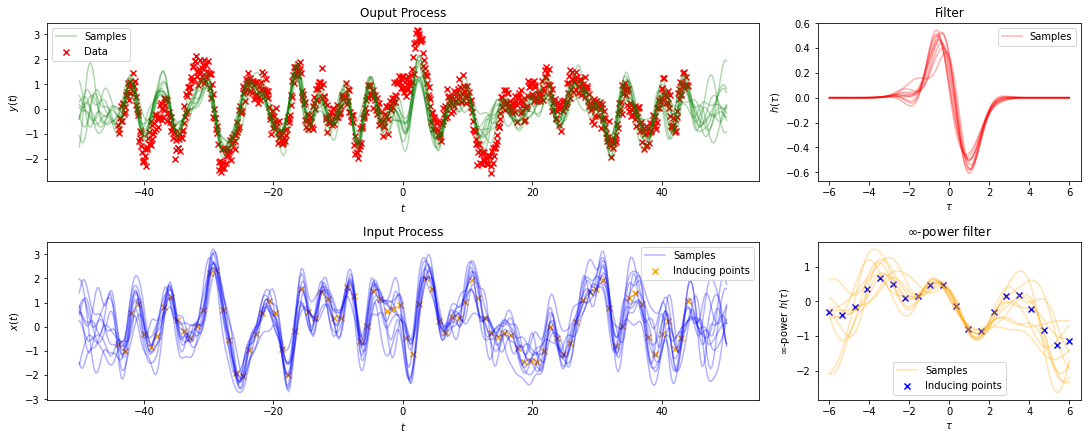

it: 101 F: 362.5887005160049 
0.998854404239576
0.8016100729537996
0.5185901687184999
0.6858522050362996
2.364751026718485
it: 102 F: 306.8426804928951 
1.0001408927038298
0.8026032496693704
0.5140095333878062
0.6855923642224152
2.3794201052695185
it: 103 F: 323.1446601595328 
1.0028316114826936
0.8036288266408471
0.5083099445069679
0.6852761222408319
2.3961422681207725
it: 104 F: 348.30789347764795 
1.003865358980122
0.8047068150265838
0.5053870626485353
0.6848971479057835
2.414021321933127
it: 105 F: 371.67383883798703 
1.0053863647631263
0.8058534887462461
0.5013410532107713
0.6844235767543925
2.430558251295804
it: 106 F: 296.6800652477704 
1.0061685005475856
0.8070988241447148
0.497922085931509
0.6838341321891701
2.4454000305310335
it: 107 F: 347.02568224999163 
1.005598809005045
0.8084213166638761
0.4942786105326831
0.683155728162197
2.4599988234675485
it: 108 F: 363.1543530780416 
1.0057394128164476
0.8097127979529675
0.4860629075393887
0.6824480117857464
2.474995308688511
it: 10

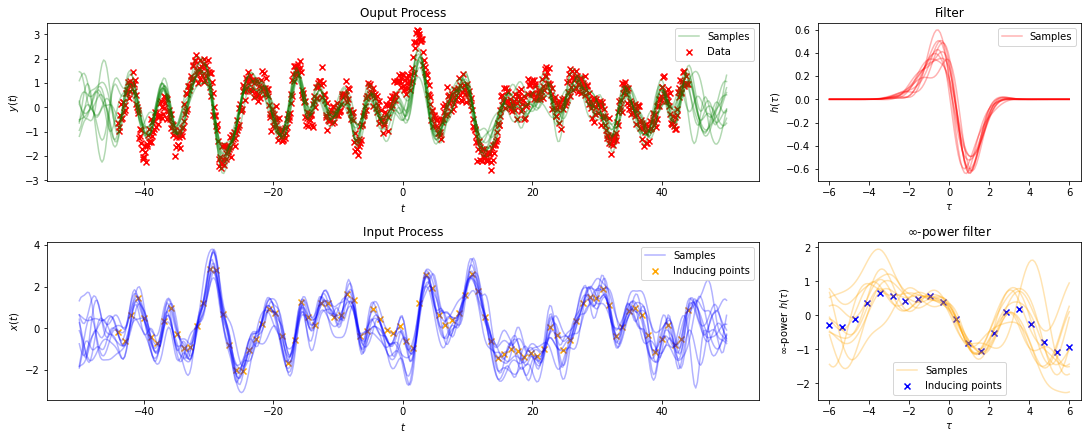

it: 151 F: 246.60232049966555 
0.9994330579201239
0.8628646470695901
0.47903285800908413
0.6593917826842545
2.8332360567121038
it: 152 F: 250.85389725529575 
0.9981284556280259
0.8640175214753115
0.47311642513580277
0.6587816367478934
2.832959554022039
it: 153 F: 212.76583222492548 
0.9977312412369361
0.8651283583256263
0.46977464753977216
0.6582014742977076
2.831589514507115
it: 154 F: 214.41179699785323 
0.9982977026346646
0.8661795341707016
0.4676196943135811
0.6576341960043295
2.8294561160052063
it: 155 F: 256.79077242870983 
0.998793415739295
0.8670980465180282
0.4665504304855531
0.6570746091565626
2.827519903941399
it: 156 F: 258.3941075574655 
0.998602156267075
0.8678446432663546
0.46510182220578733
0.6564591300925249
2.821496546503797
it: 157 F: 232.62551262688964 
0.9989197925871794
0.868472917348806
0.4646306888855631
0.6557873242206509
2.8168199755742407
it: 158 F: 245.76483977009255 
1.000588697398601
0.8691262394080862
0.4594904111691938
0.6550637717517864
2.81325122370549

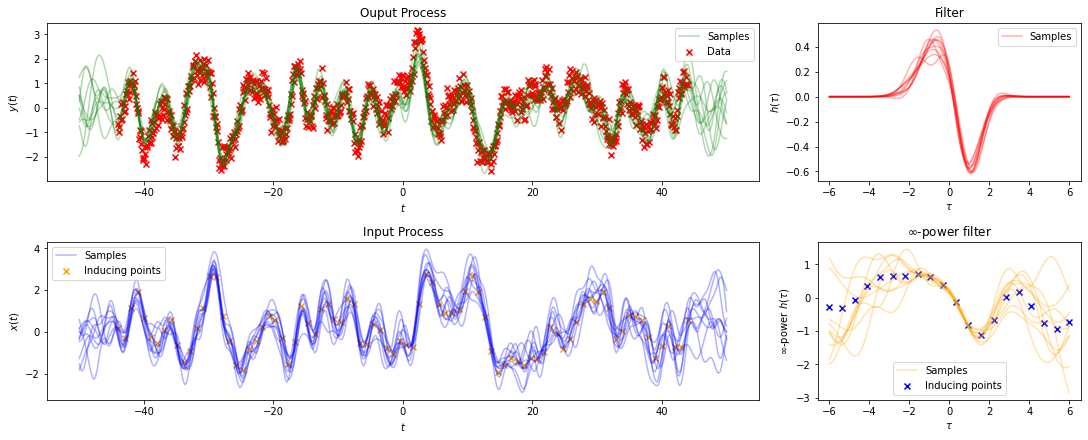

it: 201 F: 220.517405504554 
0.9973183505271926
0.8975100128618232
0.559518558057166
0.7130775139505339
2.7810992740642515
it: 202 F: 196.3178296876133 
0.9954683132050325
0.8977171678411976
0.5588664005376235
0.7171597391101863
2.796340148689427
it: 203 F: 202.63789073026737 
0.9929529884090322
0.897745481436546
0.5556242503661707
0.7197901173328156
2.810092769874332
it: 204 F: 207.4552476722582 
0.9913159551639968
0.8978647847563137
0.5517258213306889
0.7223288919067894
2.82549644229729
it: 205 F: 223.2255635806108 
0.9921667037656352
0.898185454250999
0.5452417084239829
0.7244157447507704
2.835386468631714
it: 206 F: 221.85204505383746 
0.994151666524409
0.8986578029480065
0.5393544375655989
0.7261516225265151
2.8453373816603116
it: 207 F: 201.0767732486692 
0.9957004672832331
0.8992162022811548
0.5312363378225277
0.7267909387268876
2.854591432498055
it: 208 F: 200.84727736533847 
0.9990425748820408
0.8999303163166946
0.5241974758456763
0.7279867110506957
2.8638429461805863
it: 209 

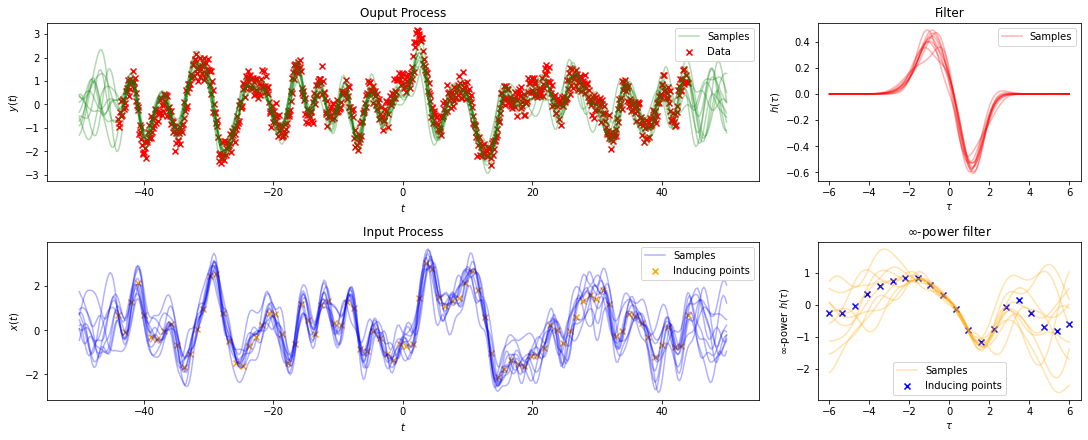

it: 251 F: 215.29648157313454 
0.9987508276867352
0.9254085325471192
0.558472715759453
0.8548590062998763
3.0501674456620833
it: 252 F: 208.08189721160068 
1.0018241807255317
0.9256409836498526
0.5514247425802963
0.8567558686145859
3.048868284705456
it: 253 F: 211.00926594129345 
1.0041340669699756
0.9258184917327195
0.5423569434828618
0.8587990857889178
3.0452615860576224
it: 254 F: 190.822046761045 
1.005813176317384
0.9259631635699943
0.53028628987967
0.8608742104596954
3.0417536910217637
it: 255 F: 182.72653681224102 
1.0051883624399034
0.9261390127055946
0.5169507111513915
0.8625810880323287
3.038710879771029
it: 256 F: 200.582090170568 
1.0018236764238704
0.9264429104709361
0.5059825494603198
0.8636916377860194
3.034142839264005
it: 257 F: 193.23453125673225 
0.9985581447299506
0.9268524098576888
0.49747218702290585
0.8649195714488159
3.03089433002824
it: 258 F: 206.71447357563324 
0.9958462096661101
0.9273588059777126
0.4861036569758269
0.8662228085870916
3.0298312423085143
it: 

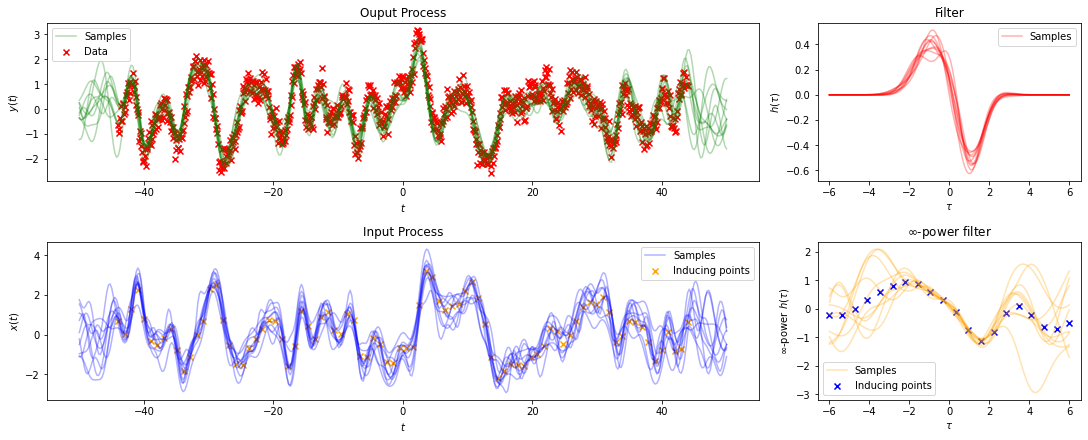

it: 301 F: 192.8432704992957 
0.9959705942959555
0.9431243207030056
0.5937379885130837
0.9617306975005003
3.203230183109508
it: 302 F: 213.9533774179956 
0.9964828410439913
0.9442749382796618
0.5868946204378411
0.9639390765148343
3.2081433093002243
it: 303 F: 183.7288165959913 
0.9988058218327145
0.9448617006194203
0.5824927074925244
0.9655204553434235
3.2126835300648637
it: 304 F: 190.5890557743366 
1.0002819635025957
0.9453590070347483
0.572917902873472
0.9666350356079676
3.2150194375298975
it: 305 F: 205.3111186515515 
0.999920025651719
0.9459944757863029
0.5600961431510598
0.9667454873848581
3.2165231330368083
it: 306 F: 196.91145581246968 
0.9995754115946706
0.9465035492874103
0.5507216916724597
0.9670396220123909
3.216756892405016
it: 307 F: 188.8235440149616 
0.9996149915020447
0.9468602595032465
0.5392602741121034
0.9676715044725618
3.216971663738436
it: 308 F: 215.1341477955999 
1.0003262995612507
0.9475249026130038
0.5264284744147609
0.9685493412583838
3.218586632966848
it: 3

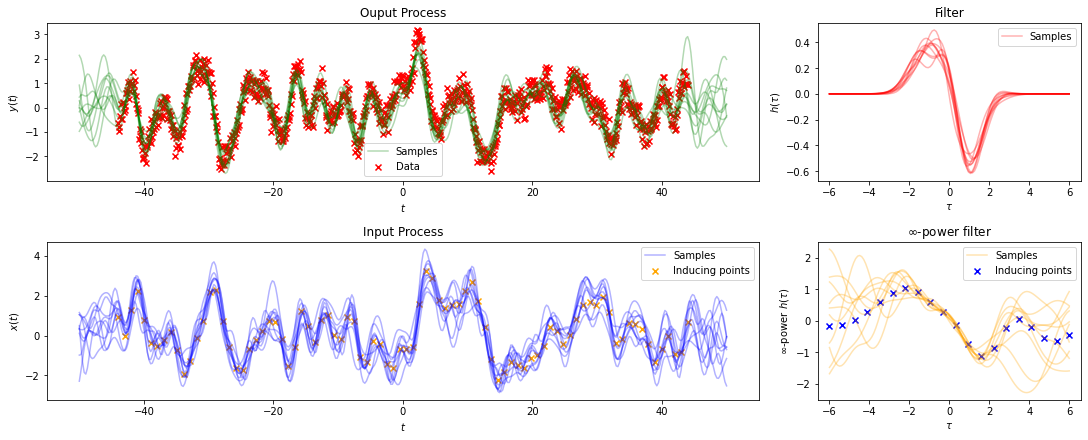

it: 351 F: 196.73456370692818 
0.9968795373764295
0.9552534404734605
0.5743018715735008
1.0412310256578226
3.2446758097330446
it: 352 F: 183.80053151895402 
0.9968339788105633
0.9555707372918579
0.5860784842132591
1.0422720068150164
3.2459375322351742
it: 353 F: 185.9019807358003 
0.9969890226162526
0.9559299728604913
0.5968509327113437
1.0433954408782213
3.248218056821286
it: 354 F: 171.17852121239977 
0.99633958719486
0.9564273198920682
0.6045979094213038
1.0439414074346163
3.2509707190419217
it: 355 F: 216.1834853684389 
0.995916452054522
0.956973859044065
0.6075297448633763
1.0448471552884389
3.250302642386456
it: 356 F: 188.15912787081174 
1.0001178071343564
0.9575580537160298
0.6116848921433428
1.04662829856953
3.252882610857804
it: 357 F: 183.93754033255874 
1.0036174533818378
0.9580641847239056
0.6159944073703073
1.0481636215286187
3.2556537536653
it: 358 F: 179.15111491707114 
1.0051949257962427
0.9583922630772229
0.6151270339023884
1.0493037027822711
3.258481087017828
it: 359

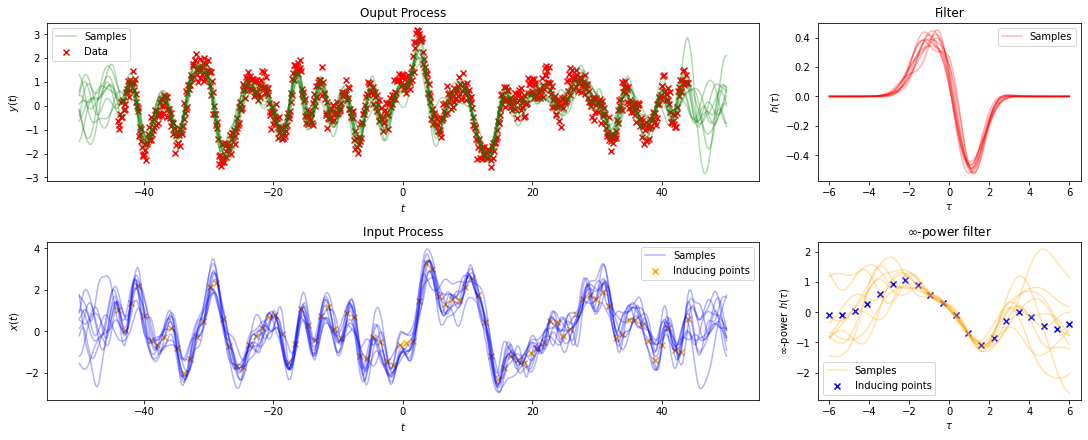

it: 401 F: 204.69938209905087 
0.9872904570894959
0.9624227166224
0.5530160840978784
1.05934965838964
3.279115440284071
it: 402 F: 187.6251404179686 
0.9932272320928528
0.9633195031735842
0.5610147820793253
1.0621360804765734
3.2818406505394835
it: 403 F: 182.73934457231442 
1.0008553202897301
0.9641412469392694
0.5700870439669146
1.0647103364182848
3.282425657692967
it: 404 F: 184.56678376161668 
1.007509036452189
0.9647177855987641
0.5793174731274514
1.0679130751480543
3.283440555531523
it: 405 F: 196.6740255724421 
1.0109897730860182
0.9650229766929598
0.5848960182258788
1.070717550317392
3.28304956467612
it: 406 F: 191.9552443598318 
1.0118945477382815
0.9649659047053176
0.588163913934242
1.073017272172352
3.2829871065053706
it: 407 F: 177.1675352168993 
1.0084081489177075
0.9644412358784061
0.5942893784257349
1.075366199766498
3.2827057292276653
it: 408 F: 199.77089986811853 
1.0045444243323094
0.9640464264954492
0.6015038728626991
1.076947865761238
3.2820454897866744
it: 409 F: 1

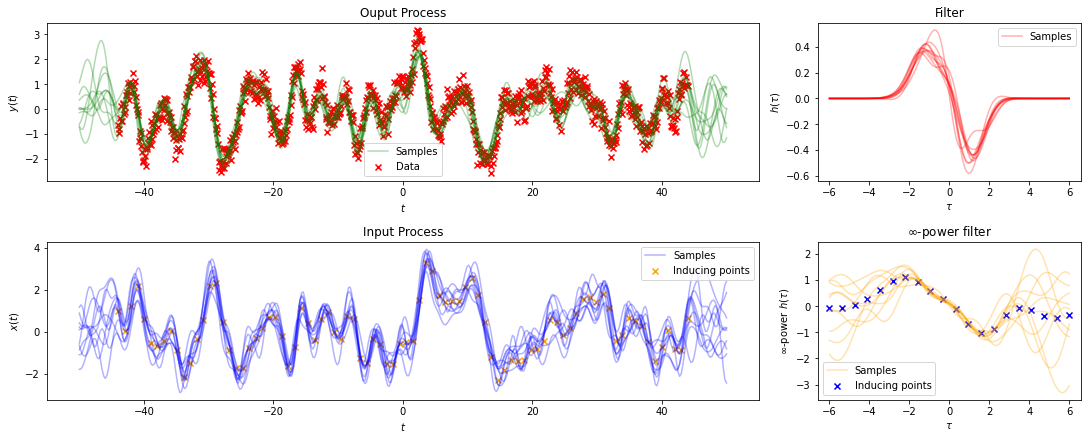

it: 451 F: 178.16536268728572 
0.9985030500585006
0.9703412868880084
0.6276597031742343
1.1094581199570626
3.262033362272921
it: 452 F: 194.63709952013443 
0.9965400173263798
0.9713713225630011
0.6251570190414265
1.1115990838201053
3.26256984190244
it: 453 F: 189.32995664485168 
0.9967301004921776
0.9723848928724567
0.62458137179673
1.113792569328909
3.264376313795767
it: 454 F: 186.21922468563835 
0.9976928268496907
0.9731689074396884
0.6236384731073666
1.1169188212452195
3.265201637140625
it: 455 F: 188.08074045619952 
1.0005233920368308
0.9738283546684369
0.6205390174994783
1.1205519115452474
3.2709501000415555
it: 456 F: 176.04293984822016 
1.0024629620061476
0.9743552522863012
0.61535973190521
1.1236431272744993
3.27603242101877
it: 457 F: 188.0831390915934 
1.002170894098192
0.974444494961884
0.6129307640778016
1.126546184447958
3.280493406121838
it: 458 F: 191.51296331665293 
1.0012496065271608
0.9743410807838931
0.6118176310645421
1.1294556711946886
3.2862517398896145
it: 459 F

0.9916782341521159
0.9757602734974042
0.6383313217970024
1.157531879771549
3.4602815030993543


In [ ]:
pars, dpars = init_pars(ts, y, zhs, zxs, key=jrnd.PRNGKey(29), a=a, lx=lx, lh=lh, sigy=sigy, sigh=1.)
maximize_bound(500, pars,  dpars, batch_size=100, lr=3e-2)


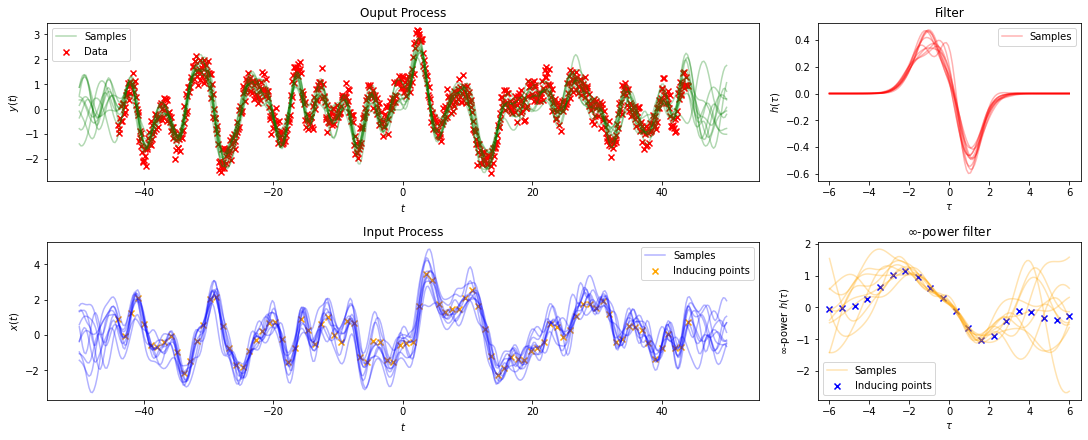

In [ ]:

plot(jnp.linspace(-50, 50, 400), ths, pars, dpars, N=10)